## Script to fit isochrones for ARMADA binaries

#### - We know delta mag in a few bands from speckle or WDS. We know delta mag in H/K bands from interferometry. We know total magnitudes in many bands from literature.
#### - In theory, we know distance from Hipparcos or Gaia (this is weakest point, as they are unresolved binaries!)

#### - Compare photometry to models using isochrones package

###### The python isochrones package is needed to run this notebook: https://isochrones.readthedocs.io/en/latest/
###### As suggested in the user guide, I prefer installing isochrones in a separate conda environment. Hence, this environment needs to be activated before running jupyter lab

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import os
import random
from astroquery.simbad import Simbad
from uncertainties import ufloat,unumpy
from uncertainties.umath import *
import pandas as pd

from isochrones.mist import MIST_EvolutionTrack, MIST_Isochrone
Mist_iso = MIST_Isochrone()
Mist_evoTrack = MIST_EvolutionTrack()

%matplotlib inline

PyMultiNest not imported.  MultiNest fits will not work.


In [2]:
matplotlib.rcParams['figure.figsize'] = (8, 5)

In [3]:
## Add quantities of interest to Simbad query -- for total magnitudes
##
## This is a good first check, but for for each target we will eventually 
## want to do a deeper literature search to make sure we are using 
## all available photometry. We should record this in the spreadsheet.

Simbad.add_votable_fields('flux(U)')
Simbad.add_votable_fields('flux(B)')
Simbad.add_votable_fields('flux(V)')
Simbad.add_votable_fields('flux(G)')
Simbad.add_votable_fields('flux(R)')
Simbad.add_votable_fields('flux(J)')
Simbad.add_votable_fields('flux(H)')
Simbad.add_votable_fields('flux(K)')
Simbad.add_votable_fields('flux_error(U)')
Simbad.add_votable_fields('flux_error(B)')
Simbad.add_votable_fields('flux_error(V)')
Simbad.add_votable_fields('flux_error(G)')
Simbad.add_votable_fields('flux_error(R)')
Simbad.add_votable_fields('flux_error(J)')
Simbad.add_votable_fields('flux_error(H)')
Simbad.add_votable_fields('flux_error(K)')

In [4]:
## Setup paths
save_directory = '/Users/tgardner/ARMADA_isochrones/' ## path for saved files
armada_file = '/Users/tgardner/Google Drive/My Drive/ARMADA_final/full_target_list.csv' ## path to csv target file
note = 'hip' ## note for saved files (e.g. 'hip' for hipparcos distance, or 'gaia')

## First select a binary target and get info from csv file

In this part, user can specify a target and query from simbad to obtain its total apparent magnitude. With the measured flux ratio, user can split the total observed magnitude in a system to separate magnitudes of individual stars. The formula is given below.
$$\Delta M = -2.5\log_{10}(f_1/f_2)~~~\Rightarrow~~~f_1 = 10^{-0.4\Delta M}f_2$$
Let $m$ be the total apparent magnitude queried from simbad, we can calculate apparent magnitude $m_1$, $m_2$ for individual targets.
$$m_1 = m-2.5\log_{10}\frac{f_1+f_2}{f_1}$$
$$m_2 = m-2.5\log_{10}\frac{f_1+f_2}{f_2}$$
To convert everything to absolute magnitude, we subtract distance modulus from the results:
$$M_i = m_i - 5\log_{10}(d/10pc)$$
We assume no extinction, and the two stars are of equal distance to us.

Note that we will likely fit to observables (i.e. total magnitude and flux ratios)

In [5]:
target_hd = '6456'
df = pd.read_csv(armada_file,dtype=object)

## Create directory for saved files, if it doesn't already exist
directory = "%s/HD_%s/"%(save_directory,target_hd)
if not os.path.exists(directory):
    print("Creating directory")
    os.makedirs(directory)

In [6]:
idx = np.where(df['HD']==target_hd)[0][0]

distance_gaia = ufloat(float(df['Gaia_distance (pc)'][idx]),float(df['Gaia_distance_err (pc)'][idx]))
distance_hip = ufloat(float(df['HIP_distance (pc)'][idx]),float(df['HIP_distance_err (pc)'][idx]))
print("distance gaia = ",distance_gaia)
print("distance hip = ",distance_hip)


cdiff_h = ufloat(float(df['dmag_h'][idx]),float(df['dmag_h_err'][idx]))
cdiff_k = ufloat(float(df['dmag_k'][idx]),float(df['dmag_k_err'][idx]))
cdiff_i = ufloat(float(df['dmag_speckle_i'][idx]),float(df['dmag_speckle_i_err'][idx]))
cdiff_b = ufloat(float(df['dmag_speckle_b'][idx]),float(df['dmag_speckle_b_err'][idx]))
cdiff_wds = ufloat(float(df['dmag_wds_v'][idx]),float(df['dmag_wds_v_err'][idx]))

fratio_h = 10**(cdiff_h/2.5)
fratio_k = 10**(cdiff_k/2.5)
fratio_i = 10**(cdiff_i/2.5)
fratio_b = 10**(cdiff_b/2.5)
fratio_wds = 10**(cdiff_wds/2.5)

print("fratio: b_mag, wds, i_mag, h_mag, k_mag = ")
print(fratio_b,',',fratio_wds,',',fratio_i,',',fratio_h,',',fratio_k)

distance gaia =  nan+/-nan
distance hip =  84+/-5
fratio: b_mag, wds, i_mag, h_mag, k_mag = 
2.11+/-0.29 , 2.2+/-0.5 , 1.91+/-0.26 , 2.1+/-0.4 , nan+/-nan


In [7]:
## choose which distance to use -- not necessarily obvious! We may want to compare both
distance = distance_hip

In [8]:
## query total magnitudes and errors from Simbad
query = Simbad.query_object('HD %s'%target_hd)

ktot = ufloat(query['FLUX_K'][0],query['FLUX_ERROR_K'][0])
utot = ufloat(query['FLUX_U'][0],query['FLUX_ERROR_U'][0])
btot = ufloat(query['FLUX_B'][0],query['FLUX_ERROR_B'][0])
rtot = ufloat(query['FLUX_R'][0],query['FLUX_ERROR_R'][0])
htot = ufloat(query['FLUX_H'][0],query['FLUX_ERROR_H'][0])
jtot = ufloat(query['FLUX_J'][0],query['FLUX_ERROR_J'][0])
vtot = ufloat(query['FLUX_V'][0],query['FLUX_ERROR_V'][0])
gtot = ufloat(query['FLUX_G'][0],query['FLUX_ERROR_G'][0])

print("U,B,V,G,R,J,H,K = ")
print(utot,',',btot,',',vtot,',',gtot,',',rtot,',',jtot,',',htot,',',ktot)

U,B,V,G,R,J,H,K = 
5.260000228881836+/-nan , 5.263+/-0.014 , 5.273+/-0.009 , 5.268+/-0.006 , nan+/-nan , 5.24+/-0.05 , 5.301+/-0.021 , 5.265+/-0.027


/Users/tgardner/opt/anaconda3/envs/isochrones/lib/python3.10/site-packages/uncertainties/core.py:2801: UserWarning: Warning: converting a masked element to nan.
  self._std_dev = CallableStdDev(std_dev)
/Users/tgardner/opt/anaconda3/envs/isochrones/lib/python3.10/site-packages/uncertainties/core.py:2766: UserWarning: Warning: converting a masked element to nan.
  value = float(value)


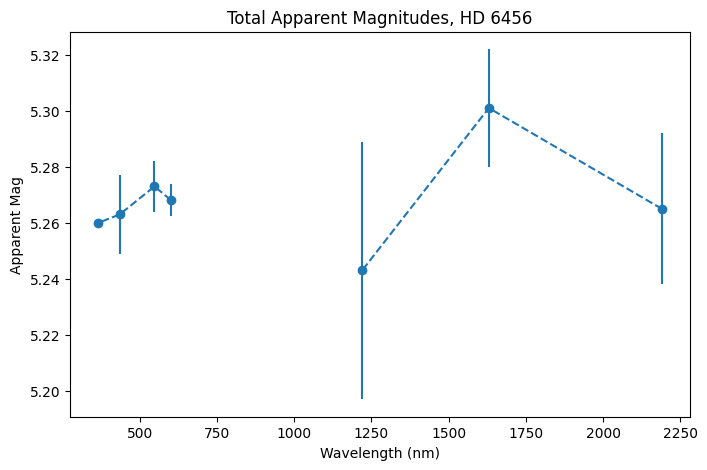

In [9]:
x = np.array([2190,1630,1220,634.9,600,547.7,435.3,365.6]) ## central wavelengths of Simbad magnitudes chosen above
y = np.array([ktot.nominal_value,htot.nominal_value,jtot.nominal_value,
              rtot.nominal_value,gtot.nominal_value,vtot.nominal_value,
              btot.nominal_value,utot.nominal_value])
yerr = np.array([ktot.std_dev,htot.std_dev,jtot.std_dev,rtot.std_dev,
                 gtot.std_dev,vtot.std_dev,btot.std_dev,utot.std_dev])

plt.title("Total Apparent Magnitudes, HD %s"%target_hd)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Apparent Mag")
plt.errorbar(x,y,yerr,fmt='o--')
plt.savefig("%s/HD_%s_%s_total_mags.pdf"%(directory,target_hd,note))
plt.show()

In [10]:
data_wave = np.array([445,551,806,1630,2190]) ## wavelengths of our speckle + interferometry data, CHECK THESE

## Compute individual magnitudes from flux ratios and total magnitudes
## Mostly for plotting. We probably won't fit to these in the end. 

k1 = -2.5*log10(10**(-ktot/2.5)/(1+10**(-cdiff_k/2.5)))
k2 = cdiff_k + k1

h1 = -2.5*log10(10**(-htot/2.5)/(1+10**(-cdiff_h/2.5)))
h2 = cdiff_h + h1

i1 = -2.5*log10(10**(-gtot/2.5)/(1+10**(-cdiff_i/2.5)))
i2 = cdiff_i + i1

v1 = -2.5*log10(10**(-vtot/2.5)/(1+10**(-cdiff_wds/2.5)))
v2 = cdiff_wds + v1

b1 = -2.5*log10(10**(-btot/2.5)/(1+10**(-cdiff_b/2.5)))
b2 = cdiff_b + b1

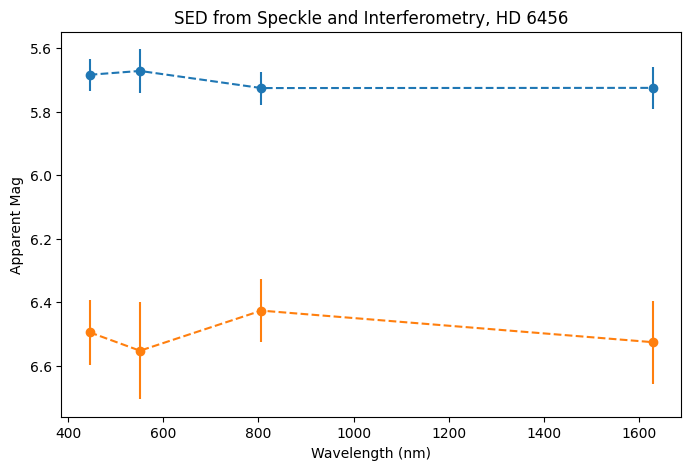

In [11]:
p1 = np.array([b1.nominal_value,v1.nominal_value,i1.nominal_value,h1.nominal_value,k1.nominal_value])
p1err = np.array([b1.std_dev,v1.std_dev,i1.std_dev,h1.std_dev,k1.std_dev])
p2 = np.array([b2.nominal_value,v2.nominal_value,i2.nominal_value,h2.nominal_value,k2.nominal_value])
p2err = np.array([b2.std_dev,v2.std_dev,i2.std_dev,h2.std_dev,k2.std_dev])

plt.title("SED from Speckle and Interferometry, HD %s"%target_hd)
plt.errorbar(data_wave,p1,p1err,fmt='o--')
plt.errorbar(data_wave,p2,p2err,fmt='o--')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Apparent Mag')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_split_mags.pdf"%(directory,target_hd,note))
plt.show()

## Now we want to use this information to fit isochrones

#### Generate tracks of multiple ages at chosen metallicity

In [12]:
feh = 0.0 ## we will want to look up this value for each target
Av = 0.0 ## targets are nearby, so extinction should be negligible

log_age_start = 6 ## starting age
log_age_size = 0.5 ## step size
log_age_steps = 7 ## number of steps

paramList  = [np.array([log_age_start,feh])+np.array([log_age_size,0])*i for i in range(0,log_age_steps)]

isoList = [Mist_iso.isochrone(param[0],param[1]) for param in paramList] 
isoList[0].head()

,eep,age,feh,mass,initial_mass,radius,density,logTeff,Teff,logg,...,H_mag,K_mag,G_mag,BP_mag,RP_mag,W1_mag,W2_mag,W3_mag,TESS_mag,Kepler_mag
55,55.0,6.0,0.042676,0.105018,0.105018,1.008661,0.144271,3.474550,2982.292493,3.448327,...,4.946742,4.716033,9.134512,11.288874,7.870188,4.586924,4.355355,4.187185,7.695528,9.280818
56,56.0,6.0,0.042676,0.109250,0.109250,1.033033,0.139711,3.476122,2993.106919,3.442495,...,4.876879,4.649098,9.057875,11.196603,7.795907,4.525382,4.295982,4.130191,7.622960,9.201681
57,57.0,6.0,0.042676,0.113478,0.113478,1.057660,0.135215,3.477692,3003.946118,3.436922,...,4.807733,4.582861,8.981869,11.104827,7.722270,4.464526,4.237317,4.073906,7.551057,9.123145
58,58.0,6.0,0.042677,0.117699,0.117699,1.082560,0.130788,3.479258,3014.798969,3.431576,...,4.739266,4.517285,8.906480,11.013557,7.649259,4.404317,4.179318,4.018287,7.479796,9.045199
59,59.0,6.0,0.042677,0.121910,0.121910,1.107756,0.126433,3.480820,3025.658920,3.426422,...,4.671423,4.452315,8.831671,10.922782,7.576834,4.344701,4.121932,3.963277,7.409135,8.967811


#### We need to add B, V, and I mag to the output of isochrones (H and K included by default)
#### Using bolometric correction grid to compute these model magnitudes

In [13]:
from isochrones.mist.bc import MISTBolometricCorrectionGrid
bc_grid_B = MISTBolometricCorrectionGrid(['B'])
bc_grid_V = MISTBolometricCorrectionGrid(['V'])
bc_grid_I = MISTBolometricCorrectionGrid(['I'])

In [14]:
# Check first few rows of bolometric correction grid
bc_grid_B.df.head()
#bc_grid_V.df.head()
#bc_grid_I.df.head()

B
Teff   logg [Fe/H] Av            
2500.0 -4.0 -4.0   0.00 -7.714880
                   0.05 -7.773749
                   0.10 -7.832595
                   0.15 -7.891418
                   0.20 -7.950218

In [15]:
# Calculating the bolometric correction in B band
Mbol_B = []
for i,iso in enumerate(isoList):
    Mbol_B.append(bc_grid_B.interp([iso['Teff'], iso['logg'], feh, Av]).ravel())   
B = []
for i,iso in enumerate(isoList):
    B.append(iso['Mbol'] - Mbol_B[i])
    
# Calculating the bolometric correction in V band
Mbol_V = []
for i,iso in enumerate(isoList):
    Mbol_V.append(bc_grid_V.interp([iso['Teff'], iso['logg'], feh, Av]).ravel())  
V = []
for i,iso in enumerate(isoList):
    V.append(iso['Mbol'] - Mbol_V[i])

# Calculating the bolometric correction in I band
Mbol_I = []
for i,iso in enumerate(isoList):
    Mbol_I.append(bc_grid_I.interp([iso['Teff'], iso['logg'], feh, Av]).ravel())  
I = []
for i,iso in enumerate(isoList):
    I.append(iso['Mbol'] - Mbol_I[i])
    
H = []
for iso in isoList:
    H.append(iso['H_mag'])

K = []
for iso in isoList:
    K.append(iso['K_mag'])

## Let's take a look at the HR diagram
#### No fitting at this point, but good to estimate starting value for age

In [16]:
print("Distance = ", distance, 'pc')
d_modulus = 5*log10(distance)-5
print("Distance Modulus = ", d_modulus)

Distance =  84+/-5 pc
Distance Modulus =  4.63+/-0.12


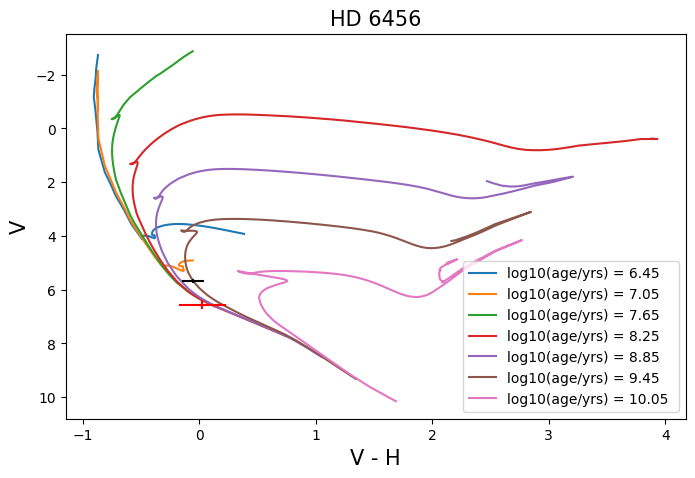

In [17]:
## change the range of plotted values in isochrones "by eye"
iso_start = 100
iso_end = 500

## Choose x/y axis. For example, V-H vs V
xval1 = v1-h1 ## component 1
yval1 = v1
xval2 = v2-h2 ## component 2
yval2 = v2

xlabel = "V - H"
ylabel = "V"

for i,iso in enumerate(isoList):
    
    ## make sure model matches data magnitudes
    modelx = V[i][iso_start:iso_end] - H[i][iso_start:iso_end]
    modely = V[i][iso_start:iso_end] + d_modulus.nominal_value
    
    plt.plot(modelx,modely,label = f"log10(age/yrs) = {6.45+0.6*i} ")

## make plot
plt.errorbar(xval1.nominal_value,yval1.nominal_value,
             xerr = xval1.std_dev, yerr = yval1.std_dev,
             color="black")
plt.errorbar(xval2.nominal_value,yval2.nominal_value,
             xerr = xval2.std_dev, yerr = yval2.std_dev,
             color="red")
        
plt.xlabel(xlabel,fontsize=15)
plt.ylabel(ylabel, fontsize=15)
plt.gca().invert_yaxis()
plt.title("HD %s"%target_hd, fontsize = 15)
plt.legend()
plt.savefig("%s/HD_%s_%s_hr_diagram.pdf"%(directory,target_hd,note))
plt.show()

## Now let's do a MCMC fit for masses and age

In the fitting, the likelihood function is given by:
$$\mathcal{L} = \exp\left(-\sum_i \left(\frac{\Delta M_{i,\text{tot}}}{\sigma_{\Delta_{M_{i,\text{tot}}}}}\right)^2 + \left(\frac{\Delta (M_{i,1}-M_{i,2})}{\sigma_{\Delta (M_{i,1}-M_{i,2})}}\right)^2\right)$$

Hence, we are fitting to the total magnitudes and color differences. The model functions below returns an $\chi$-array. 

In [18]:
from isochrones import get_ichrone
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit
import corner
tracks = get_ichrone('mist', tracks=True, accurate=True)

In [19]:
## Objective function to be minimized for lmfit
def isochrone_model(params, TOT_mag_star, D_mag_star, TOT_mag_star_err, D_mag_star_err, d_modulus, Av):
    
    age = params['age']
    m1 = params['mass1']
    m2 = params['mass2']
    feh = params['feh']
    
    a1 = tracks.generate(m1, age, feh, return_dict=True)
    a2 = tracks.generate(m2, age, feh, return_dict=True)
    
    #if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
    #    return np.inf
    
    mag1_model = np.array([(a1['Mbol'] - bc_grid_B.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_V.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      (a1['Mbol'] - bc_grid_I.interp([a1['Teff'], a1['logg'], feh, Av ])+d_modulus)[0][0],
                      a1["H_mag"]+d_modulus,
                      a1["K_mag"]+d_modulus])

    mag2_model = np.array([(a2['Mbol'] - bc_grid_B.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_V.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      (a2['Mbol'] - bc_grid_I.interp([a2['Teff'], a2['logg'], feh, Av ])+d_modulus)[0][0],
                      a2["H_mag"]+d_modulus,
                      a2["K_mag"]+d_modulus])

    D_mag_model = mag2_model - mag1_model
    TOT_mag_model = -2.5*np.log10(10**(-0.4*mag1_model)+10**(-0.4*mag2_model))
  
    diff1 = (D_mag_star - D_mag_model) / D_mag_star_err
    diff2 = (TOT_mag_star - TOT_mag_model) / TOT_mag_star_err

    return np.concatenate([diff1,diff2])

#### Important note: If the age is too high for a given mass, the model photometry will return all nan (massive stars have shorter lifetimes). This can kill the fitting. 
##### Here we will set a max mass and age for fitting. This could take some tweaking. If chosen max mass is too high (and hence age too low), you may miss the solution! The MCMC posteriors should help...

In [20]:
max_mass = 2.6 ## choose a maximum mass to fit for, you then need to set an appropriate maximum age!
min_feh = 0
max_feh = 0

age_test = np.linspace(6,10,100)
for tt in age_test:
    a1 = tracks.generate(max_mass, tt, min_feh, return_dict=True)
    if np.isnan(a1['Mbol']):
        print("Max log(age) = %s, for mass = %s Msun"%(tt, max_mass))
        max_age = tt
        break

Max log(age) = 8.868686868686869, for mass = 2.6 Msun


In [21]:
## if you want to set a lower max age:
#max_age = 8.26

In [22]:
## Choose observables for fitting
TOT_Mag = np.array([btot, vtot, gtot, htot, ktot])
DiffM = np.array([cdiff_b, cdiff_wds, cdiff_i, cdiff_h, cdiff_k])

In [23]:
## start with a chi2 fit (this does not always work)

## NOTE --> Since isochrones has a fixed age grid, the fitting currently fails to optimize this parameter
## We can search age on a grid, or change the default step size for the parameter

params = Parameters()
params.add('age',   value= 8.3, min=6, max=max_age)
params.add('mass1', value= 2, min=0, max=max_mass)
params.add('mass2', value= 1, min=0, max=max_mass)
params.add('feh', value = 0, vary=False)#min=-0.5, max=0.5)

minner = Minimizer(isochrone_model, params, fcn_args=(unumpy.nominal_values(TOT_Mag), unumpy.nominal_values(DiffM), 
                                                      unumpy.std_devs(TOT_Mag), unumpy.std_devs(DiffM), 
                                                      d_modulus.nominal_value, Av),
                   nan_policy='omit')
result = minner.minimize()
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 32
    # data points      = 9
    # variables        = 3
    chi-square         = 4.77116127
    reduced chi-square = 0.79519355
    Akaike info crit   = 0.28828636
    Bayesian info crit = 0.87996009
##  Warning: uncertainties could not be estimated:
    age:    at initial value
[[Variables]]
    age:    8.30000000 (init = 8.3)
    mass1:  2.37762311 (init = 2)
    mass2:  1.89047301 (init = 1)
    feh:    0 (fixed)


In [24]:
## Setup MCMC fit
emcee_params = result.params.copy()
nwalkers = 2*len(emcee_params)
steps = 50000
burn = 10000
thin = 100

In [25]:
emcee_params

name,value,initial value,min,max,vary
age,8.30000000,8.3,6.00000000,8.86868687,True
mass1,2.37762311,2,0.00000000,2.60000000,True
mass2,1.89047301,1,0.00000000,2.60000000,True
feh,0.00000000,0,-inf,inf,False


In [26]:
## Do MCMC fit (this cell could take some time, depending on steps)
minner = Minimizer(isochrone_model, emcee_params, fcn_args=(unumpy.nominal_values(TOT_Mag),
                                                            unumpy.nominal_values(DiffM),
                                                            unumpy.std_devs(TOT_Mag),
                                                            unumpy.std_devs(DiffM),
                                                            d_modulus.nominal_value, Av),
                   nan_policy='omit')
result = minner.minimize(method='emcee',steps=steps,burn=burn,thin=thin,nwalkers=nwalkers)
print(report_fit(result))

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [03:01<00:00, 274.88it/s]

[[Fit Statistics]]
    # fitting method   = emcee
    # function evals   = 400000
    # data points      = 9
    # variables        = 3
    chi-square         = 4.85489288
    reduced chi-square = 0.80914881
    Akaike info crit   = 0.44486214
    Bayesian info crit = 1.03653587
[[Variables]]
    age:    8.29050713 +/- 0.06214132 (0.75%) (init = 8.3)
    mass1:  2.38478375 +/- 0.03371451 (1.41%) (init = 2.377623)
    mass2:  1.88908281 +/- 0.03141682 (1.66%) (init = 1.890473)
    feh:    0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(age, mass1)   = -0.830
    C(mass1, mass2) = -0.422
    C(age, mass2)   = -0.132
None


#### Now let's plot some MCMC outputs
##### Need to make more plots to check convergence, etc

In [27]:
chains = result.flatchain

## save chains (so we don't need to run large ones again)
print(chains.shape)
np.save("%s/HD_%s_%s_chains.npy"%(directory,target_hd,note),chains)

(3200, 3)


In [28]:
## load chains -- NOTE: Could start from here if a run has already been completed
chains = np.load("%s/HD_%s_%s_chains.npy"%(directory,target_hd,note))

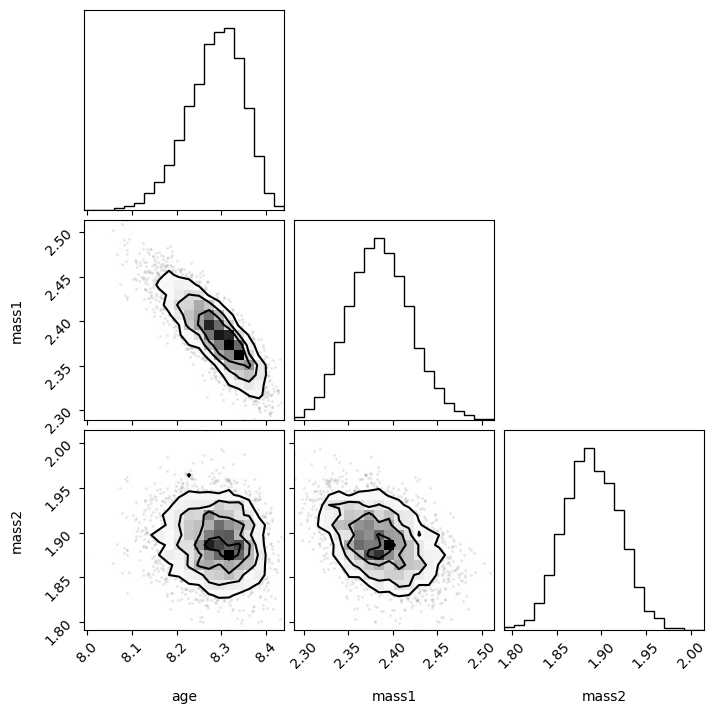

In [29]:
try:
    emcee_plot = corner.corner(chains,labels=result.var_names)
    plt.savefig('%s/HD_%s_%s_corner.pdf'%(directory,target_hd,note))
except:
    print(result.var_names)
    emcee_plot = corner.corner(chains)
    plt.savefig('%s/HD_%s_%s_corner.pdf'%(directory,target_hd,note))

#### Compute best model to make plots

In [30]:
age_chain = chains[:,0]
mass1_chain = chains[:,1]
mass2_chain = chains[:,2]

age_best = np.mean(age_chain)
mass1_best = np.mean(mass1_chain)
mass2_best = np.mean(mass2_chain)

age_err = np.std(age_chain)
mass1_err = np.std(mass1_chain)
mass2_err = np.std(mass2_chain)

In [31]:
age = ufloat(age_best,age_err)
mass1 = ufloat(mass1_best,mass1_err)
mass2 = ufloat(mass2_best,mass2_err)

In [32]:
print('Log Age = ', age)
print('M1 (solar) = ', mass1)
print('M2 (solar) = ', mass2)
print('Msum (solar) = ', mass1+mass2)

Log Age =  8.29+/-0.06
M1 (solar) =  2.386+/-0.034
M2 (solar) =  1.890+/-0.031
Msum (solar) =  4.28+/-0.05


In [33]:
a1_best = tracks.generate(mass1_best, age_best, feh, return_dict=True)
a2_best = tracks.generate(mass2_best, age_best, feh, return_dict=True)
    
#if np.isnan(a1['Mbol']) or np.isnan(a2['Mbol']):
#    return np.inf
    
model1 = np.array([(a1_best['Mbol'] - bc_grid_B.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus.nominal_value)[0],
                  (a1_best['Mbol'] - bc_grid_V.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus.nominal_value)[0],
                  (a1_best['Mbol'] - bc_grid_I.interp([a1_best['Teff'], a1_best['logg'], feh, Av ])+d_modulus.nominal_value)[0],
                  a1_best["H_mag"]+d_modulus.nominal_value,
                  a1_best["K_mag"]+d_modulus.nominal_value])

model2 = np.array([(a2_best['Mbol'] - bc_grid_B.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus.nominal_value)[0],
                  (a2_best['Mbol'] - bc_grid_V.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus.nominal_value)[0],
                  (a2_best['Mbol'] - bc_grid_I.interp([a2_best['Teff'], a2_best['logg'], feh, Av ])+d_modulus.nominal_value)[0],
                  a2_best["H_mag"]+d_modulus.nominal_value,
                  a2_best["K_mag"]+d_modulus.nominal_value])

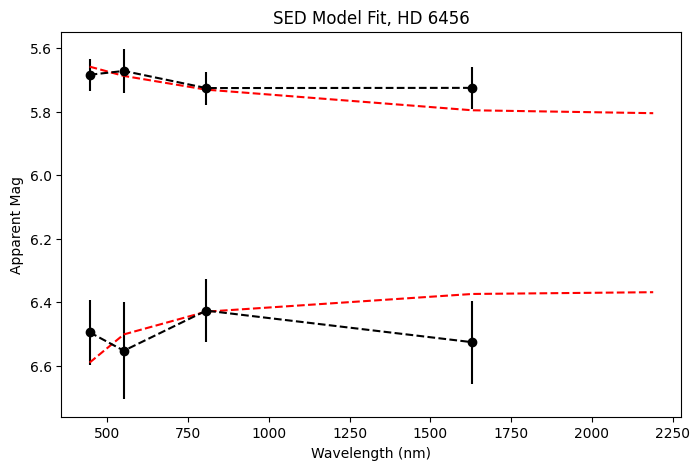

In [34]:
## SED plot with best fit
plt.title("SED Model Fit, HD %s"%target_hd)
plt.errorbar(data_wave,p1,p1err,fmt='o--',color='black')
plt.errorbar(data_wave,p2,p2err,fmt='o--',color='black')

plt.plot(data_wave,model1,'--',color='red')
plt.plot(data_wave,model2,'--',color='red')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Apparent Mag')
plt.gca().invert_yaxis()
plt.savefig("%s/HD_%s_%s_sed_fit.pdf"%(directory,target_hd,note))
plt.show()